In [ ]:
import os
# change the path to the root of the project directory if not in "project-5" directory
while os.path.basename(os.getcwd()) != "project-5":
    os.chdir("..")
print(f"Current working directory: {os.getcwd()}")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils.model_runner import evaluate_models, plot_predicted_vs_true, plot_regression_metrics, plot_residuals
from src.utils.preprocess import GeneExpPreprocessor
from src.utils.data_handler import DataHandler
from sklearn.feature_selection import SelectKBest, f_regression

DH = DataHandler()

Current working directory: /home/chris/code/ucsd/beng285/breast-cancer-team-1/project-5


<h1>Load GE and PFS</h1>

In [2]:
GEP = GeneExpPreprocessor(auto_preprocess=False, top_N=250)
GEP._load_expr()
GEP._log1p_tpm_normalization()
GEP._subset()
all_exp = GEP.get_df()

metadata = pd.read_csv('data/raw/brca_tcga_pan_can_atlas_2018_clinical_data_PAM50_subype_and_progression_free_survival.tsv', sep='\t', index_col=[1,2])
pfs = metadata['Progress Free Survival (Months)']

n_patients = all_exp.index.get_level_values("patient_id").nunique()
n_samples = all_exp.index.get_level_values("sample_id").nunique()
print(f"There are {n_patients} patients and {n_samples} samples in the dataset.")

Loaded matrix with 1132 samples x 20531 genes
Parsing gencode fasta file: data/raw/gencode.v23lift37.pc_transcripts.fa
Finding longest CDS length for each gene
Normalizing expression data to log1p(TPM)
Subsetting to top 250 genes using method: dndscv
There are 1018 patients and 1132 samples in the dataset.


<h1>Align indices for df_exp and PFS</h2>

In [3]:
df_exp = all_exp.copy()

def truncate_sample_id(s):
    parts = s.split('-')
    if len(parts) >= 4:
        return '-'.join(parts[:4])[:-1]
    else:
        return s

new_index = df_exp.index.set_levels(
    df_exp.index.levels[1].map(truncate_sample_id),
    level=1
)

df_exp.index = new_index

<h1>Generate X and y</h1>

In [4]:
X = df_exp.copy()

# remove samples with nan pfs values
pfs = pfs.dropna()

# get intersection of samples in X and pfs
intersection_samples = X.index.intersection(pfs.index)

# filter to keep only samples in the intersection
X = X.loc[intersection_samples]
pfs = pfs.loc[intersection_samples]
y = list(pfs)

<h1>Define filtering and evaluate models with 5-fold CV</h1>

In [5]:
def training_fold_filtering(X: pd.DataFrame, y: list[float]) -> tuple[pd.DataFrame, list[str]]:
    """
    Filtering logic should be implemented here. Then it will be applied to each cross validation training fold

    Takes in the DataFrame X and the list of target values y, applies filtering, and returns the filtered DataFrame and its column names (features)
        which will be used to subset the test fold data.

    Filter logic:
    1. Filter by mean expression across samples, keeping genes with a mean expression greater than 1.
    2. Choose top 100 features based on univariate feature selection using f_regression.
    """
    X = DH.filter_by_mean(X, 1)
    X = DH.filter_by_variance(X, 0.1)
    k = 10
    if len(X.columns) < k:
        print(f"Warning: Less than {k} features after mean and variance filtering. Found {len(X.columns)} features.")
        print(f"Using all {len(X.columns)} features.")
        k = len(X.columns)

    selector = SelectKBest(score_func=f_regression, k=100)
    X_new = selector.fit_transform(X, y)
    selected_genes = X.columns[selector.get_support()].tolist()
    return pd.DataFrame(X_new, columns=selected_genes, index=X.index), selected_genes

results = evaluate_models(X, y, filter_data=training_fold_filtering)

<h1>plot data</h1>

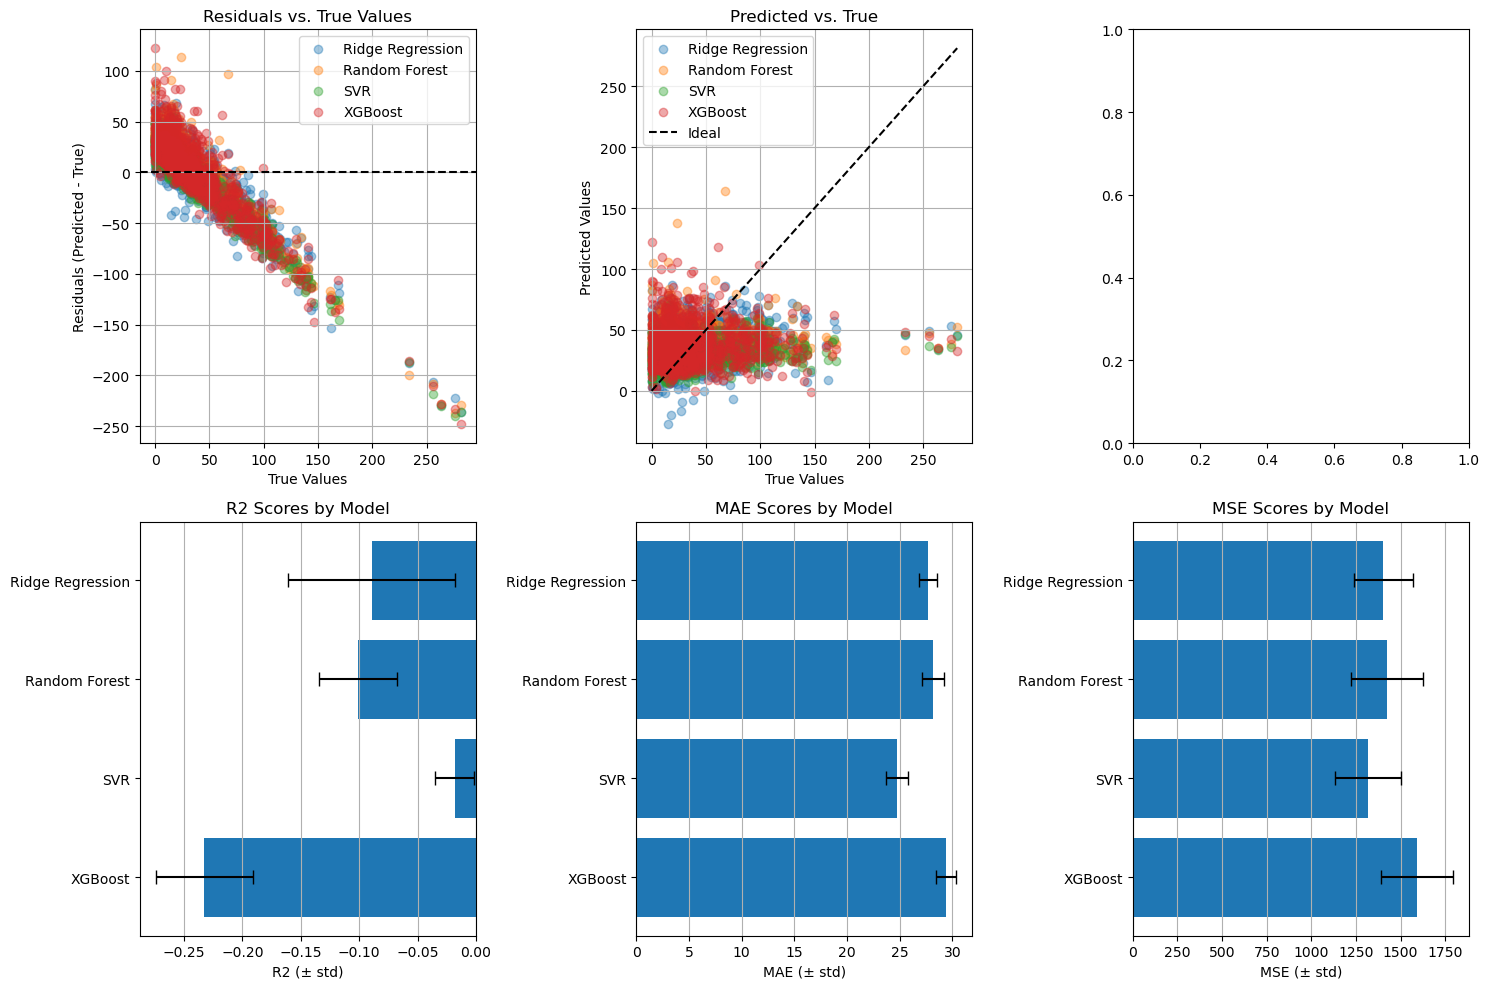

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

plot_residuals(results, ax=axes[0, 0])
plot_predicted_vs_true(results, ax=axes[0, 1])
plot_regression_metrics(results, ax=axes[1,0], metric='R2')
plot_regression_metrics(results, ax=axes[1,1], metric='MAE')
plot_regression_metrics(results, ax=axes[1,2], metric='MSE')

fig.tight_layout()

Text(0.5, 1.0, 'XGBoost True Values Distribution')

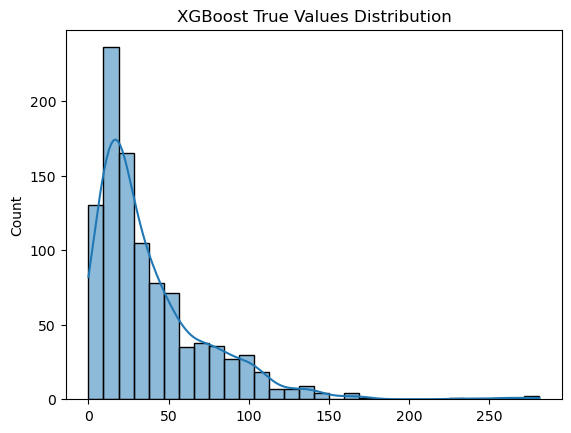

In [7]:
ax = sns.histplot(results['XGBoost']['y_true'], bins=30, kde=True)
ax.set_title('XGBoost True Values Distribution')

Text(0.5, 1.0, 'XGBoost Predicted Values Distribution')

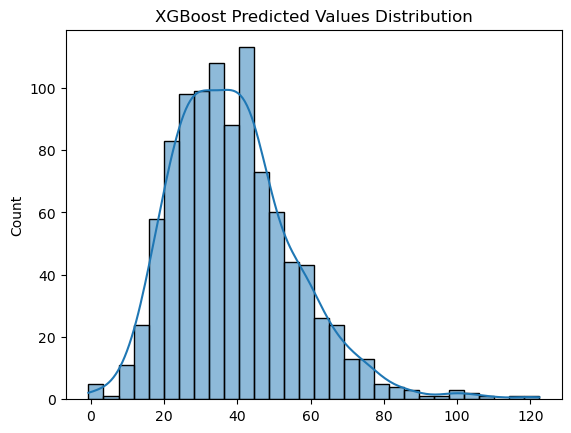

In [8]:
ax = sns.histplot(results['XGBoost']['y_pred'], bins=30, kde=True)
ax.set_title('XGBoost Predicted Values Distribution')

In [9]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

def filter_data(X: pd.DataFrame, y: np.ndarray, top_k: int = 100):
    """
    Selects top_k genes most correlated with y (within training fold only).
    Assumes X is already log1p-TPM transformed and subset to top 250 dNdScv genes.
    """
    # Compute Pearson correlation per gene
    correlations = X.apply(lambda col: np.corrcoef(col, y)[0, 1])
    top_genes = correlations.abs().nlargest(top_k).index
    return X[top_genes], top_genes.tolist()


def evaluate_models2(X: pd.DataFrame, y: list, models: dict = None, random_state=42, cv_folds: int = 5, filter_data: callable = None):
    y_array = np.asarray(y, dtype=float)

    if models is None:
        models = {
            'Ridge Regression': make_pipeline(StandardScaler(), Ridge()),
            'Random Forest': RandomForestRegressor(),
            'SVR': make_pipeline(StandardScaler(), SVR()),
            'XGBoost': XGBRegressor()
        }

    if filter_data is None:
        def filter_data(X: pd.DataFrame, y: np.ndarray):
            return X, X.columns.tolist()

    results = {}
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    for name, model in models.items():
        r2_scores, mses, maes, spears, yt, yp = [], [], [], [], [], []
        for train_idx, test_idx in kf.split(X, y_array):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y_array[train_idx], y_array[test_idx]

            # Fold-specific feature filtering
            X_train_filtered, features = filter_data(X_train, y_train)
            X_test_filtered = X_test.loc[:, features]

            # Scale y
            y_scaler = StandardScaler()
            y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()

            # Fit and predict
            model.fit(X_train_filtered, y_train_scaled)
            y_pred_scaled = model.predict(X_test_filtered)
            y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

            # Metrics
            r2_scores.append(r2_score(y_test, y_pred))
            mses.append(mean_squared_error(y_test, y_pred))
            maes.append(mean_absolute_error(y_test, y_pred))
            spears.append(spearmanr(y_test, y_pred).correlation)
            yt.append(y_test)
            yp.append(y_pred)

        results[name] = {
            'R2': {'mean': np.mean(r2_scores), 'std': np.std(r2_scores), 'scores': r2_scores},
            'MSE': {'mean': np.mean(mses), 'std': np.std(mses), 'scores': mses},
            'MAE': {'mean': np.mean(maes), 'std': np.std(maes), 'scores': maes},
            'Spearman': {'mean': np.mean(spears), 'std': np.std(spears), 'scores': spears},
            'features': features,
            'y_true': np.concatenate(yt),
            'y_pred': np.concatenate(yp)
        }

    return results
